In [1]:
#bs0

In [2]:
leishu=3

In [27]:
import torch

device0 = torch.device('cuda:5' if torch.cuda.is_available() else "cpu")#训练集gpu
device1 = torch.device('cuda:7' if torch.cuda.is_available() else "cpu")#测试集gpu

In [4]:
import pandas as pd
data=pd.read_table('./data/test.txt',header=None)#text label
data.columns = ['text', 'label']
text=[i for i in data['text']]
label=[i for i in data['label']]

In [5]:
from transformers import AutoTokenizer, AutoModel
# added_token=['##char##']
# tokenizer = AutoTokenizer.from_pretrained("bert-base-chinese",additional_special_tokens=added_token)
tokenizer = AutoTokenizer.from_pretrained("bert-base-chinese")
def text2token(text,tokenizer,max_length=100):
    text2id = tokenizer(
        text, max_length=max_length, padding='max_length', truncation=True, return_tensors="pt"
    )
    input_ids=text2id["input_ids"].tolist()
    attention_mask=text2id["attention_mask"].tolist()
    return input_ids,attention_mask

input_ids,attention_mask=text2token(text,tokenizer,max_length=100)

data['input_ids']=input_ids
data['attention_mask']=attention_mask
# print(data.head())

In [6]:
train_data = data.sample(frac=0.8)
test_data=data[~data.index.isin(train_data.index)]
print(len(train_data),len(test_data))
train_data=train_data.reset_index(drop=True)
test_data=test_data.reset_index(drop=True)

from torch.utils.data import Dataset
class SentimentDataset(Dataset):
    def __init__(self,df):
        self.dataset = df
    def __len__(self):
        return len(self.dataset)
    def __getitem__(self, idx):
        text = self.dataset.loc[idx, "text"]
        label = self.dataset.loc[idx, "label"]
        input_ids = self.dataset.loc[idx, "input_ids"]
        attention_mask = self.dataset.loc[idx, "attention_mask"]
        sample = {"text": text, "label": label,"input_ids":input_ids,"attention_mask":attention_mask}
        # print(sample)
        return sample
    
#按batch_size分
from torch.utils.data import DataLoader,TensorDataset
import numpy as np
import torch

batch_size=16
train_loader = DataLoader(
    SentimentDataset(train_data), 
    batch_size=batch_size, 
    shuffle=True, 
    num_workers=0
)
test_loader = DataLoader(
    SentimentDataset(test_data), 
    batch_size=batch_size, 
    shuffle=False, 
    num_workers=0
)

240 60


In [7]:
from transformers import AutoTokenizer, AutoModel
import torch.nn as nn
import torch.nn.functional as F

class fn_cls(nn.Module):
    def __init__(self,device):
        super(fn_cls, self).__init__()
        self.model = AutoModel.from_pretrained("bert-base-chinese")
        self.model.resize_token_embeddings(len(tokenizer))##############
        self.model.to(device)
#         self.dropout = nn.Dropout(0.5)
        self.l1 = nn.Linear(768, leishu)

    def forward(self, x, attention_mask=None):
        outputs = self.model(x, attention_mask=attention_mask)
#         print(outputs[0])torch.Size([8, 100, 768])
#         print(outputs[1])torch.Size([8, 768])
#         print(outputs[0][:,0,:])torch.Size([8, 768])
        x = outputs[1]
#         x = self.dropout(x)
        x = self.l1(x)
        return x
cls = fn_cls(device0)

from torch import optim
optimizer = optim.Adam(cls.parameters(), lr=1e-4)

Some weights of the model checkpoint at bert-base-chinese were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [9]:
softmax = nn.Softmax()
criterion = nn.CrossEntropyLoss()#weight=weight
### 我的类别数为12
# criterion = nn.CrossEntropyLoss(weight=torch.from_numpy(np.array([0.1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0])).float() ,
#                                 size_average=True)


In [15]:
from sklearn import metrics
import numpy as np
from tqdm import tqdm

def test(device_test):
    cls.to(device_test)
    cls.eval()

    epoch_loss=0
    total=0
    correct=0
    output_all=[]
    label_all=[]
    for batch_idx,batch in enumerate(test_loader):
        with torch.no_grad():
            label=batch['label'].to(device_test)#batch size * 1
            label_all.append(label.view(-1,1))
            input_ids=torch.stack(batch['input_ids']).t().to(device_test)#batch size * 100
            attention_mask=torch.stack(batch['attention_mask']).t().to(device_test)#batch size * 100
            
            #计算输出
            output = cls(input_ids, attention_mask=attention_mask)#batch size * 1
            total+=len(output)
            
            #计算loss
            
#             print(output,label)
            loss = criterion(output, label)
            epoch_loss+=loss
            ave_loss=epoch_loss/total
            
            #四舍五入
            output=softmax(output)
            output=output.argmax(dim=1)
            output_all.append(output)
            
            #计算准确率
            add_correct=(output== label).sum().item()
            correct+=add_correct
            acc=correct/total
            
            if batch_idx%5==0:
                print('[{}/{} ({:.0f}%)]\t正确分类的样本数：{}，样本总数：{}，准确率：{:.2f}%，ave_loss：{}'.format(
                    batch_idx, len(test_loader),100.*batch_idx/len(test_loader), 
                    correct, total,acc,
                    ave_loss
                    ),end= "\r")
            
            
            
    #结束：
    print('正确分类的样本数：{}，样本总数：{}，准确率：{:.2f}%，ave_loss：{}'.format(
                    correct, total,acc,
                    ave_loss))
    
#     can't convert cuda:5 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.
    output_all=torch.cat(output_all,0)
    label_all=torch.cat(label_all,0)
    
    output_all=np.array(output_all.cpu())
    label_all=np.array(label_all.cpu())
    acc_score=metrics.accuracy_score(output_all, label_all)
    print(metrics.classification_report(output_all, label_all))
    print("准确率:",acc_score )
    
    return acc,epoch_loss.item()

test(device1)

正确分类的样本数：20，样本总数：60，准确率：0.33%，ave_loss：0.06895820796489716
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.00      0.00      0.00         0
           2       1.00      0.33      0.50        60

    accuracy                           0.33        60
   macro avg       0.33      0.11      0.17        60
weighted avg       1.00      0.33      0.50        60

准确率: 0.3333333333333333


/data/fuwen/anaconda3/envs/bs0/lib/python3.7/site-packages/ipykernel_launcher.py:33: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/data/fuwen/anaconda3/envs/bs0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/data/fuwen/anaconda3/envs/bs0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/data/fuwen/anaconda3/envs/bs0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are i

(0.3333333333333333, 4.1374921798706055)

In [18]:
train_acc_l=[]
train_epoch_loss_l=[]
test_acc_l=[]
test_epoch_loss_l=[]

def train_one_epoch(device_train,epoch_num):
    print("______________________________________________")
    print("______________________________________________")
    print("_______________",epoch_num,"start_______________")
    print("______________________________________________")
    print("______________________________________________")
    cls.to(device_train)
    cls.train()

    epoch_loss=0
    total=0
    correct=0
    output_all=[]
    label_all=[]
    for batch_idx,batch in enumerate(train_loader):
        label=batch['label'].to(device_train)#batch size * 1
        label_all.append(label.view(-1,1))
        input_ids=torch.stack(batch['input_ids']).t().to(device_train)#batch size * 100
        attention_mask=torch.stack(batch['attention_mask']).t().to(device_train)#batch size * 100

        #计算输出
        output = cls(input_ids, attention_mask=attention_mask)#batch size * 1

        #计算loss
        loss = criterion(output, label)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
            
        with torch.no_grad():
            #四舍五入
            output=softmax(output)
            output=output.argmax(dim=1)
            output_all.append(output)
            total+=len(output)
            
            #epoch_loss
            epoch_loss+=loss
            ave_loss=epoch_loss/total
            
            #计算准确率
            add_correct=(output== label).sum().item()
            correct+=add_correct
            acc=correct/total
            
            if batch_idx%5==0:
                print('[{}/{} ({:.0f}%)]\t正确分类的样本数：{}，样本总数：{}，准确率：{:.2f}%，ave_loss：{}'.format(
                    batch_idx, len(train_loader),100.*batch_idx/len(train_loader), 
                    correct, total,acc,
                    ave_loss
                    ),end= "\r")
            
            
            
    #结束：
    print('正确分类的样本数：{}，样本总数：{}，准确率：{:.2f}%，ave_loss：{}'.format(
                    correct, total,acc,
                    ave_loss))
    
#     can't convert cuda:5 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.
    with torch.no_grad():
        output_all=torch.cat(output_all,0)
        label_all=torch.cat(label_all,0)

        output_all=np.array(output_all.cpu())
        label_all=np.array(label_all.cpu())
        acc_score=metrics.accuracy_score(output_all, label_all)
        
    print(metrics.classification_report(output_all, label_all))
    print("准确率:",acc_score )
    
    test_acc,test_epoch_loss=test(device1)
    print('train_acc:',acc,'train_epoch_loss:',epoch_loss.item(),'test_acc:',test_acc,'test_epoch_loss:',test_epoch_loss)
    train_acc_l.append(acc)
    train_epoch_loss_l.append(epoch_loss.item())
    test_acc_l.append(test_acc)
    test_epoch_loss_l.append(test_epoch_loss)
    print("______________________________________________")
    print("______________________________________________")
    print("_______________",epoch_num,"end_______________")
    print("______________________________________________")
    print("______________________________________________")
    

def train():
    epoch_num=10
    for i in range(epoch_num):
        train_one_epoch(device0,i)

    
# train_one_epoch(device0,0)
train()

______________________________________________
______________________________________________
_______________ 0 start_______________
______________________________________________
______________________________________________


/data/fuwen/anaconda3/envs/bs0/lib/python3.7/site-packages/ipykernel_launcher.py:37: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


正确分类的样本数：240，样本总数：240，准确率：1.00%，ave_loss：0.0001724458415992558701180619653314
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        85
           1       1.00      1.00      1.00        75
           2       1.00      1.00      1.00        80

    accuracy                           1.00       240
   macro avg       1.00      1.00      1.00       240
weighted avg       1.00      1.00      1.00       240

准确率: 1.0
正确分类的样本数：60，样本总数：60，准确率：1.00%，ave_loss：5.2118415624136105e-05482018e-05
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        15
           1       1.00      1.00      1.00        25
           2       1.00      1.00      1.00        20

    accuracy                           1.00        60
   macro avg       1.00      1.00      1.00        60
weighted avg       1.00      1.00      1.00        60

准确率: 1.0
train_acc: 1.0 train_epoch_loss: 0.04138699918985367 test_acc: 1.0 tes

/data/fuwen/anaconda3/envs/bs0/lib/python3.7/site-packages/ipykernel_launcher.py:33: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/data/fuwen/anaconda3/envs/bs0/lib/python3.7/site-packages/ipykernel_launcher.py:37: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


正确分类的样本数：240，样本总数：240，准确率：1.00%，ave_loss：4.812880797544494e-059566386007e-05
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        85
           1       1.00      1.00      1.00        75
           2       1.00      1.00      1.00        80

    accuracy                           1.00       240
   macro avg       1.00      1.00      1.00       240
weighted avg       1.00      1.00      1.00       240

准确率: 1.0
正确分类的样本数：60，样本总数：60，准确率：1.00%，ave_loss：2.571463119238615e-0556867164e-05
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        15
           1       1.00      1.00      1.00        25
           2       1.00      1.00      1.00        20

    accuracy                           1.00        60
   macro avg       1.00      1.00      1.00        60
weighted avg       1.00      1.00      1.00        60

准确率: 1.0
train_acc: 1.0 train_epoch_loss: 0.01155091356486082 test_acc: 1.0 tes

/data/fuwen/anaconda3/envs/bs0/lib/python3.7/site-packages/ipykernel_launcher.py:33: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/data/fuwen/anaconda3/envs/bs0/lib/python3.7/site-packages/ipykernel_launcher.py:37: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


正确分类的样本数：240，样本总数：240，准确率：1.00%，ave_loss：2.852325633284636e-0578829246387e-05
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        85
           1       1.00      1.00      1.00        75
           2       1.00      1.00      1.00        80

    accuracy                           1.00       240
   macro avg       1.00      1.00      1.00       240
weighted avg       1.00      1.00      1.00       240

准确率: 1.0
正确分类的样本数：60，样本总数：60，准确率：1.00%，ave_loss：1.801116559363436e-0510817038e-05
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        15
           1       1.00      1.00      1.00        25
           2       1.00      1.00      1.00        20

    accuracy                           1.00        60
   macro avg       1.00      1.00      1.00        60
weighted avg       1.00      1.00      1.00        60

准确率: 1.0
train_acc: 1.0 train_epoch_loss: 0.006845581345260143 test_acc: 1.0 t

/data/fuwen/anaconda3/envs/bs0/lib/python3.7/site-packages/ipykernel_launcher.py:33: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/data/fuwen/anaconda3/envs/bs0/lib/python3.7/site-packages/ipykernel_launcher.py:37: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


正确分类的样本数：240，样本总数：240，准确率：1.00%，ave_loss：2.1776915673399344e-05366476629e-05
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        85
           1       1.00      1.00      1.00        75
           2       1.00      1.00      1.00        80

    accuracy                           1.00       240
   macro avg       1.00      1.00      1.00       240
weighted avg       1.00      1.00      1.00       240

准确率: 1.0
正确分类的样本数：60，样本总数：60，准确率：1.00%，ave_loss：1.460474231862463e-0531029046e-05
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        15
           1       1.00      1.00      1.00        25
           2       1.00      1.00      1.00        20

    accuracy                           1.00        60
   macro avg       1.00      1.00      1.00        60
weighted avg       1.00      1.00      1.00        60

准确率: 1.0
train_acc: 1.0 train_epoch_loss: 0.005226459354162216 test_acc: 1.0 te

/data/fuwen/anaconda3/envs/bs0/lib/python3.7/site-packages/ipykernel_launcher.py:33: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/data/fuwen/anaconda3/envs/bs0/lib/python3.7/site-packages/ipykernel_launcher.py:37: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


正确分类的样本数：240，样本总数：240，准确率：1.00%，ave_loss：1.8448745322530158e-058039640263e-05
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        85
           1       1.00      1.00      1.00        75
           2       1.00      1.00      1.00        80

    accuracy                           1.00       240
   macro avg       1.00      1.00      1.00       240
weighted avg       1.00      1.00      1.00       240

准确率: 1.0
正确分类的样本数：60，样本总数：60，准确率：1.00%，ave_loss：1.2605792107933667e-058878092e-05
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        15
           1       1.00      1.00      1.00        25
           2       1.00      1.00      1.00        20

    accuracy                           1.00        60
   macro avg       1.00      1.00      1.00        60
weighted avg       1.00      1.00      1.00        60

准确率: 1.0
train_acc: 1.0 train_epoch_loss: 0.004427698440849781 test_acc: 1.0 t

/data/fuwen/anaconda3/envs/bs0/lib/python3.7/site-packages/ipykernel_launcher.py:33: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/data/fuwen/anaconda3/envs/bs0/lib/python3.7/site-packages/ipykernel_launcher.py:37: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


正确分类的样本数：240，样本总数：240，准确率：1.00%，ave_loss：1.6099838830996305e-05112803787e-05
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        85
           1       1.00      1.00      1.00        75
           2       1.00      1.00      1.00        80

    accuracy                           1.00       240
   macro avg       1.00      1.00      1.00       240
weighted avg       1.00      1.00      1.00       240

准确率: 1.0
正确分类的样本数：60，样本总数：60，准确率：1.00%，ave_loss：1.0986826964654028e-05253204e-06
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        15
           1       1.00      1.00      1.00        25
           2       1.00      1.00      1.00        20

    accuracy                           1.00        60
   macro avg       1.00      1.00      1.00        60
weighted avg       1.00      1.00      1.00        60

准确率: 1.0
train_acc: 1.0 train_epoch_loss: 0.0038639612030237913 test_acc: 1.0 te

/data/fuwen/anaconda3/envs/bs0/lib/python3.7/site-packages/ipykernel_launcher.py:33: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/data/fuwen/anaconda3/envs/bs0/lib/python3.7/site-packages/ipykernel_launcher.py:37: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


正确分类的样本数：240，样本总数：240，准确率：1.00%，ave_loss：1.4270955944084562e-052538554035e-05
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        85
           1       1.00      1.00      1.00        75
           2       1.00      1.00      1.00        80

    accuracy                           1.00       240
   macro avg       1.00      1.00      1.00       240
weighted avg       1.00      1.00      1.00       240

准确率: 1.0
正确分类的样本数：60，样本总数：60，准确率：1.00%，ave_loss：9.801750820770394e-069017554e-06
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        15
           1       1.00      1.00      1.00        25
           2       1.00      1.00      1.00        20

    accuracy                           1.00        60
   macro avg       1.00      1.00      1.00        60
weighted avg       1.00      1.00      1.00        60

准确率: 1.0
train_acc: 1.0 train_epoch_loss: 0.0034250293392688036 test_acc: 1.0 t

/data/fuwen/anaconda3/envs/bs0/lib/python3.7/site-packages/ipykernel_launcher.py:33: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/data/fuwen/anaconda3/envs/bs0/lib/python3.7/site-packages/ipykernel_launcher.py:37: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


正确分类的样本数：240，样本总数：240，准确率：1.00%，ave_loss：1.273112229682738e-0554512007814e-05
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        85
           1       1.00      1.00      1.00        75
           2       1.00      1.00      1.00        80

    accuracy                           1.00       240
   macro avg       1.00      1.00      1.00       240
weighted avg       1.00      1.00      1.00       240

准确率: 1.0
正确分类的样本数：60，样本总数：60，准确率：1.00%，ave_loss：8.698972123966087e-063706203e-06
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        15
           1       1.00      1.00      1.00        25
           2       1.00      1.00      1.00        20

    accuracy                           1.00        60
   macro avg       1.00      1.00      1.00        60
weighted avg       1.00      1.00      1.00        60

准确率: 1.0
train_acc: 1.0 train_epoch_loss: 0.0030554691329598427 test_acc: 1.0 t

/data/fuwen/anaconda3/envs/bs0/lib/python3.7/site-packages/ipykernel_launcher.py:33: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/data/fuwen/anaconda3/envs/bs0/lib/python3.7/site-packages/ipykernel_launcher.py:37: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


正确分类的样本数：240，样本总数：240，准确率：1.00%，ave_loss：1.1647207429632545e-05894553747e-05
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        85
           1       1.00      1.00      1.00        75
           2       1.00      1.00      1.00        80

    accuracy                           1.00       240
   macro avg       1.00      1.00      1.00       240
weighted avg       1.00      1.00      1.00       240

准确率: 1.0
正确分类的样本数：60，样本总数：60，准确率：1.00%，ave_loss：7.872682544984855e-063349414e-06
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        15
           1       1.00      1.00      1.00        25
           2       1.00      1.00      1.00        20

    accuracy                           1.00        60
   macro avg       1.00      1.00      1.00        60
weighted avg       1.00      1.00      1.00        60

准确率: 1.0
train_acc: 1.0 train_epoch_loss: 0.002795329550281167 test_acc: 1.0 tes

/data/fuwen/anaconda3/envs/bs0/lib/python3.7/site-packages/ipykernel_launcher.py:33: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/data/fuwen/anaconda3/envs/bs0/lib/python3.7/site-packages/ipykernel_launcher.py:37: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


正确分类的样本数：240，样本总数：240，准确率：1.00%，ave_loss：1.0635920261847787e-055254987478e-05
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        85
           1       1.00      1.00      1.00        75
           2       1.00      1.00      1.00        80

    accuracy                           1.00       240
   macro avg       1.00      1.00      1.00       240
weighted avg       1.00      1.00      1.00       240

准确率: 1.0
正确分类的样本数：60，样本总数：60，准确率：1.00%，ave_loss：7.168434422055725e-06780856e-06
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        15
           1       1.00      1.00      1.00        25
           2       1.00      1.00      1.00        20

    accuracy                           1.00        60
   macro avg       1.00      1.00      1.00        60
weighted avg       1.00      1.00      1.00        60

准确率: 1.0
train_acc: 1.0 train_epoch_loss: 0.0025526208337396383 test_acc: 1.0 te

/data/fuwen/anaconda3/envs/bs0/lib/python3.7/site-packages/ipykernel_launcher.py:33: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


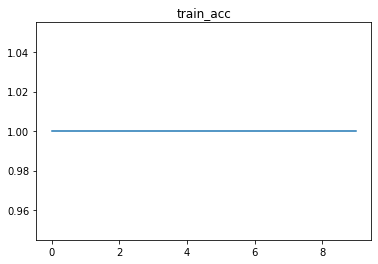

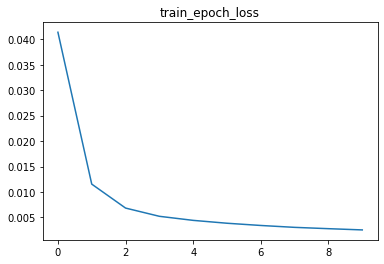

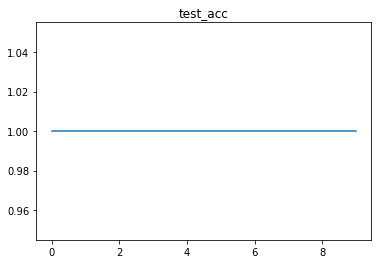

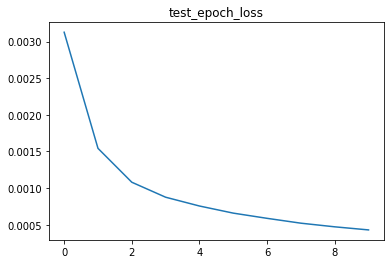

In [19]:
import matplotlib.pyplot as plt
def _plt():
    plt.plot([i for i in range(len(train_acc_l))], train_acc_l)
    plt.title('train_acc')
    plt.show()
    plt.plot([i for i in range(len(train_epoch_loss_l))], train_epoch_loss_l)
    plt.title('train_epoch_loss')
    plt.show()
    plt.plot([i for i in range(len(test_acc_l))], test_acc_l)
    plt.title('test_acc')
    plt.show()
    plt.plot([i for i in range(len(test_epoch_loss_l))], test_epoch_loss_l)
    plt.title('test_epoch_loss')
    plt.show()
_plt()

In [20]:
cls = fn_cls(device0)

from torch import optim
optimizer = optim.Adam(cls.parameters(), lr=1e-4)
test(device1)
train_one_epoch(device0,0)

Some weights of the model checkpoint at bert-base-chinese were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/data/fuwen/anaconda3/envs/bs0/lib/python3.7/site-packages/ipykernel_launcher.py:33: UserWarning: Implicit dimension choice for softmax has been deprecated

正确分类的样本数：15，样本总数：60，准确率：0.25%，ave_loss：0.066197969019413
              precision    recall  f1-score   support

           0       1.00      0.38      0.55        40
           1       0.00      0.00      0.00        20
           2       0.00      0.00      0.00         0

    accuracy                           0.25        60
   macro avg       0.33      0.12      0.18        60
weighted avg       0.67      0.25      0.36        60

准确率: 0.25
______________________________________________
______________________________________________
_______________ 0 start_______________
______________________________________________
______________________________________________


/data/fuwen/anaconda3/envs/bs0/lib/python3.7/site-packages/ipykernel_launcher.py:37: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


正确分类的样本数：225，样本总数：240，准确率：0.94%，ave_loss：0.0124261016026139267124032974243
              precision    recall  f1-score   support

           0       0.95      0.96      0.96        84
           1       0.96      0.90      0.93        80
           2       0.90      0.95      0.92        76

    accuracy                           0.94       240
   macro avg       0.94      0.94      0.94       240
weighted avg       0.94      0.94      0.94       240

准确率: 0.9375
正确分类的样本数：60，样本总数：60，准确率：1.00%，ave_loss：0.000429940933827310871918576211
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        15
           1       1.00      1.00      1.00        25
           2       1.00      1.00      1.00        20

    accuracy                           1.00        60
   macro avg       1.00      1.00      1.00        60
weighted avg       1.00      1.00      1.00        60

准确率: 1.0
train_acc: 0.9375 train_epoch_loss: 2.982264280319214 test_acc: 1.0 te

/data/fuwen/anaconda3/envs/bs0/lib/python3.7/site-packages/ipykernel_launcher.py:33: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


In [ ]:
import time
end = time.time()
torch.save(cls,"../data/cls_"+str(end)+".model")

In [ ]:
import torch
cls=torch.load("../data/cls.model",map_location=device0)

In [29]:
def predict(device,s_l,cls):
    with torch.no_grad():
        cls.to(device)
        cls.eval()
        text2id = tokenizer(
            s_l, max_length=100, padding='max_length', truncation=True, return_tensors="pt"
        )
        input_ids=text2id["input_ids"].to(device)
        mask=text2id["attention_mask"].to(device)
        output = cls(input_ids, attention_mask=mask)

        output1=softmax(output)
        output2=output.argmax(dim=1)
        return output1,output2
    
    
    
    


In [30]:
s=['好好好','中中中','差差差']
print(predict(device1,s,cls))

(tensor([[0.9933, 0.0039, 0.0028],
        [0.0040, 0.9915, 0.0045],
        [0.0144, 0.0067, 0.9789]], device='cuda:7'), tensor([0, 1, 2], device='cuda:7'))


/data/fuwen/anaconda3/envs/bs0/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  if sys.path[0] == '':
